In [1]:
import tensorflow as tf 
import tensorflow_io as tfio
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow_addons as tfa
import cv2
from skimage import io, color
from tensorflow.data import AUTOTUNE

%matplotlib inline

In [2]:
tf.__version__

'2.10.1'

In [3]:
# data path 

face_path = r"D:\data\cartoonset10k"

In [4]:
images = os.listdir(path=face_path)
images = [os.path.join(face_path, image) for image in images if image.endswith(".png")]
len(images)

10000

In [5]:
list_ds = tf.data.Dataset.list_files(images, shuffle=False)
list_ds = list_ds.shuffle(len(images),reshuffle_each_iteration=False)

In [6]:
for f in list_ds.take(5):
    print(f.numpy())

b'D:\\data\\cartoonset10k\\cs10374580130698089738.png'
b'D:\\data\\cartoonset10k\\cs10844144293531735941.png'
b'D:\\data\\cartoonset10k\\cs10372945365292987398.png'
b'D:\\data\\cartoonset10k\\cs10460605334909651521.png'
b'D:\\data\\cartoonset10k\\cs1100003105848706574.png'


In [7]:
image_count = len(images)

val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [8]:
width = 128
height = 128

In [9]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img1 = tf.io.decode_jpeg(img, channels=3)
  img1 = tf.image.resize(img1, [width, height])
  img1 = tf.cast(img1, tf.float32) / 255.
  
  img3 = tfio.experimental.color.rgb_to_lab(img1)
  img2 = tf.image.rgb_to_grayscale(img1)
  return img2, img3

def process_path(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img2, img3 = decode_img(img)
  return img2, img3


train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [10]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(4)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

0.99990004
0.99990004
0.99990004
0.99990004


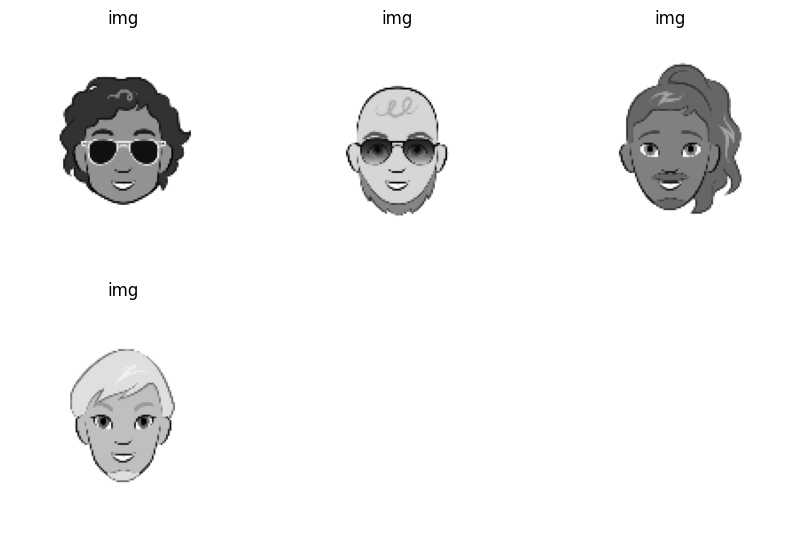

In [11]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(4):
  ax = plt.subplot(3, 3, i + 1)
  img = image_batch[i].numpy() 
  print(img.max())
  # img *= 255
  # i = i.astype("uint8")
  plt.imshow(img, cmap='gray')
#   label = label_batch[i]
  plt.title("img")
  plt.axis("off")

1.0
1.0
1.0
1.0


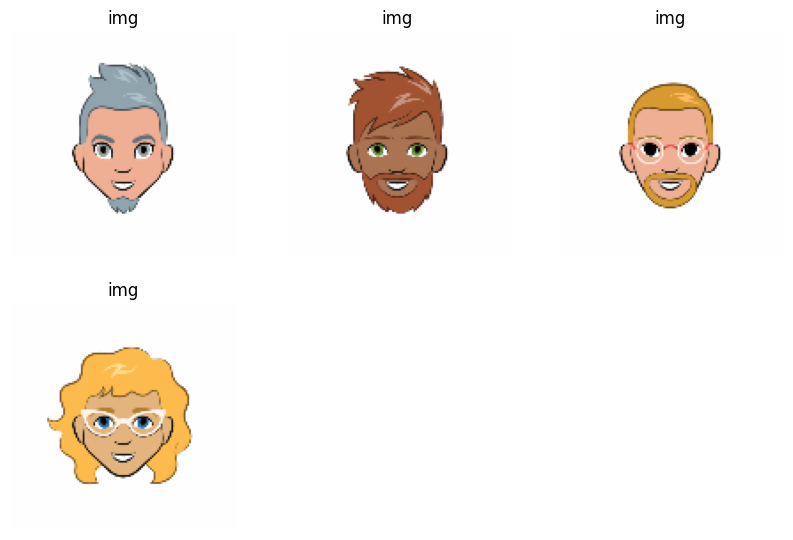

In [12]:
image_batch1, image_batch2 = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(4):
  ax = plt.subplot(3, 3, i + 1)
  img = image_batch2[i].numpy() 
  img = color.lab2rgb(img)
  print(img.max())
  # img *= 255
  # i = i.astype("uint8")
  plt.imshow(img)
#   label = label_batch[i]
  plt.title("img")
  plt.axis("off")

In [13]:
image_batch[0].shape, image_batch2[0].shape

(TensorShape([128, 128, 1]), TensorShape([128, 128, 3]))

In [40]:
# Build encoder decoder model using keras functional API

from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, UpSampling2D, GaussianNoise
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

def create_model():
  
  model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(128, 128, 1)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
  ])
  
  model.compile(optimizer='adam', loss='mse')
  return model


colorizer = create_model()
early_stopping = EarlyStopping(monitor='loss', patience=50)

            
        


In [41]:
colorizer.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 128, 128, 64)      640       
                                                                 
Total params: 640
Trainable params: 640
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = colorizer.fit(train_ds,validation_data= val_ds, epochs=20, batch_size=32, callbacks=[early_stopping])

Epoch 1/20
2000/2000 [==============================] - 12s 5ms/step - loss: 2893.3391 - val_loss: 2892.5427
Epoch 2/20
2000/2000 [==============================] - 10s 5ms/step - loss: 2893.2546 - val_loss: 2892.5422
Epoch 3/20
2000/2000 [==============================] - 10s 5ms/step - loss: 2893.2554 - val_loss: 2892.5415
Epoch 4/20
2000/2000 [==============================] - 10s 5ms/step - loss: 2893.2542 - val_loss: 2892.5427
Epoch 5/20
2000/2000 [==============================] - 10s 5ms/step - loss: 2893.2524 - val_loss: 2892.6326
Epoch 6/20
2000/2000 [==============================] - 10s 5ms/step - loss: 2893.2529 - val_loss: 2892.5525
Epoch 7/20
2000/2000 [==============================] - 10s 5ms/step - loss: 2893.2488 - val_loss: 2892.5962
Epoch 8/20
2000/2000 [==============================] - 11s 5ms/step - loss: 2893.2493 - val_loss: 2892.5408
Epoch 9/20
2000/2000 [==============================] - 10s 5ms/step - loss: 2893.2478 - val_loss: 2892.5376
Epoch 10/20
2000/20

KeyboardInterrupt: 

In [28]:
i = next(iter(train_ds))

o = colorizer.predict(i[0][:1])
# o = tf.clip_by_value(o[0], clip_value_min=0., clip_value_max=1.)


1/1 [==============================] - 0s 24ms/step


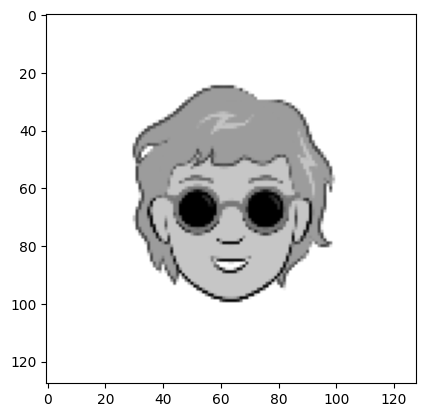

In [29]:
plt.imshow(i[0][0].numpy(), cmap='gray')

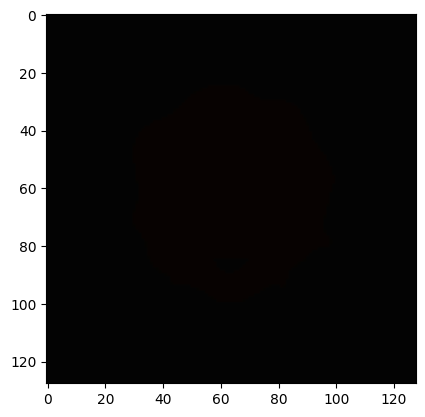

In [34]:
o1 = color.lab2rgb(o[0])

plt.imshow(o1)

In [32]:
o1

array([[[0.01430335, 0.0143031 , 0.01430441],
        [0.01430335, 0.0143031 , 0.01430441],
        [0.01430335, 0.0143031 , 0.01430441],
        ...,
        [0.01430335, 0.0143031 , 0.01430441],
        [0.01430335, 0.0143031 , 0.01430441],
        [0.01430335, 0.0143031 , 0.01430441]],

       [[0.01430335, 0.0143031 , 0.01430441],
        [0.01430335, 0.0143031 , 0.01430441],
        [0.01430335, 0.0143031 , 0.01430441],
        ...,
        [0.01430335, 0.0143031 , 0.01430441],
        [0.01430335, 0.0143031 , 0.01430441],
        [0.01430335, 0.0143031 , 0.01430441]],

       [[0.01430335, 0.0143031 , 0.01430441],
        [0.01430335, 0.0143031 , 0.01430441],
        [0.01430335, 0.0143031 , 0.01430441],
        ...,
        [0.01430335, 0.0143031 , 0.01430441],
        [0.01430335, 0.0143031 , 0.01430441],
        [0.01430335, 0.0143031 , 0.01430441]],

       ...,

       [[0.01430335, 0.0143031 , 0.01430441],
        [0.01430335, 0.0143031 , 0.01430441],
        [0.01430335, 0